# Named Entity Recognition (NER) 

In [86]:
import pandas as pd
import random
import numpy as np
import json
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf
import os
from math import nan
from pandas import read_csv
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import itertools
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import RNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from pandas import read_csv
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import math
from future.utils import iteritems
from numpy import savetxt
from numpy import asarray
from numpy import savez_compressed
from statistics import mean
from tensorflow.keras import layers
from collections import Counter
from conlleval import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel



# Table of contents<a class="anchor" id="m"></a>

* [Data Preparation](#one)
    * [Loading in initial datasets](#1.1)
    * [Exploratory data analysis on BIO tags](#1.2)
    * [Changing dataframe to join all sentences](#1.3)
    * [Preprocessing: Tokenizing, padding and encoding](#1.4)
        * [a) Tokenizing](#1.41)
        * [b) Padding sentences](#1.42)
        * [c) Encoding label BIO tag](#1.43)
    * [Train, test, validation split](#1.5)
* [Model Training](#two)
    * [ Initial model training with validation and test](#2.1)
    * [Training model on full set of data](#2.2)
    * [Testing model on random sentences](#2.3)
* [Implementing transfer learning](#three)
    * [Prepare Data in correct format for pretrained model](#3.1)
    * [Making model and training](#3.2)
    * [Testing model](#3.3)


Find the Aggregated dataset at: https://www.kaggle.com/naseralqaydeh/named-entity-recognition-ner-corpus

# Data Preparation<a class="anchor" id="one"></a>
[Contents Page](#m)

## Loading in initial datasets<a class="anchor" id="1.1"></a>

In [2]:
#Basic dataset
data_path = "ner_dataset.csv"

data = pd.read_csv(data_path, encoding= 'unicode_escape')
# filling the first column that determines which sentence each word belongs to.
data.fillna(method = 'ffill', inplace = True)
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [3]:
#loadng in trigram version
ready_data = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
ready_data.head()

b'Skipping line 281837: expected 25 fields, saw 34\n'


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [4]:
# Exploting a single full sentence
def join_a_sentence(sentence_number):

    """
    Args.:
          sentence_number: sentence number we want to join and return. 
          
    Returns:
          The joined sentence.
    """
    
    sentence_number = str(sentence_number)
    the_sentence_words_list = list(data[data['Sentence #'] == 'Sentence: {}'.format(sentence_number)]['Word'])
    
    return ' '.join(the_sentence_words_list)

In [5]:
join_a_sentence(sentence_number = 1)

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [6]:
join_a_sentence(sentence_number = 100)

'Helicopter gunships Saturday pounded militant hideouts in the Orakzai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South Waziristan .'

In [7]:
# Data Shape
data.shape

(1048575, 4)

In [8]:
# Number of unique sentences
len(np.unique(data['Sentence #']))

47959

In [9]:
print("Number of unique words in the dataset: {}".format(data.Word.nunique()))
print("Number of unique tags in the dataset: {}".format(data.Tag.nunique()))

Number of unique words in the dataset: 35178
Number of unique tags in the dataset: 17


## Exploratory data analysis on BIO tags<a class="anchor" id="1.2"></a>

In [10]:
tags = data.Tag.unique()
tags

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [11]:
def num_words_tags (tags, data):
    
    """This functions takes the tags we want to count and the datafram 
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""
    
    tags_count = {}
    
    for tag in tags:
        len_tag = len(data[data['Tag'] == tag])
        tags_count[tag] = len_tag
    
    return tags_count

In [12]:
tags_count = num_words_tags(tags, data)
tags_count

{'O': 887908,
 'B-geo': 37644,
 'B-gpe': 15870,
 'B-per': 16990,
 'I-geo': 7414,
 'B-org': 20143,
 'I-org': 16784,
 'B-tim': 20333,
 'B-art': 402,
 'I-art': 297,
 'I-per': 17251,
 'I-gpe': 198,
 'I-tim': 6528,
 'B-nat': 201,
 'B-eve': 308,
 'I-eve': 253,
 'I-nat': 51}

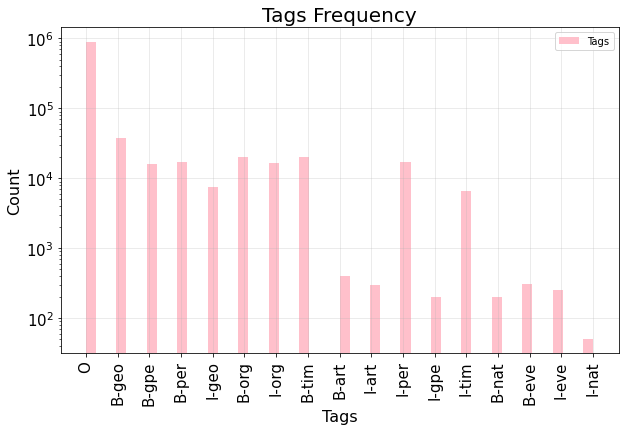

In [13]:
plt.figure(figsize = (10, 6))
plt.hist(data.Tag, log = True, label = 'Tags', color = 'pink', bins = 50)
plt.xlabel('Tags', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title("Tags Frequency", fontsize = 20)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=90)
plt.show()

## Changing dataframe to join all sentences<a class="anchor" id="1.3"></a>

In [14]:
#Sentence preproc
def process_Data():
    
    data_dict = {}
    
    for sn in range(1, len(np.unique(data['Sentence #']))+1):
        
        all_sen_data = []
        
        se_data = data[data['Sentence #']  == 'Sentence: {}'.format(sn)]
        sentence = ' '.join(list(se_data['Word']))
        all_sen_data.append(sentence)
        
        sen_pos = list(se_data['POS'])
        all_sen_data.append(sen_pos)
        
        sen_tags = list(se_data['Tag'])
        all_sen_data.append(sen_tags)
        
        data_dict['Sentence: {}'.format(sn)] = all_sen_data
        
        if sn % 10000 == 0:
            print("{} sentences are processed".format(sn))
        
    return data_dict
ready_data=process_Data()

10000 sentences are processed
20000 sentences are processed
30000 sentences are processed
40000 sentences are processed


In [15]:
fml=pd.DataFrame.from_dict(ready_data, orient='index',columns=['Sentence', 'POS', 'Tag'])

In [17]:
#fml.to_pickle('readiORnut')  # where to save it, usually as a .pkl
ready_data = pd.read_pickle('readiORnut')


In [18]:
ready_data

,Sentence,POS,Tag
Sentence: 1,Thousands of demonstrators have marched throug...,"[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
Sentence: 2,Families of soldiers killed in the conflict jo...,"[NNS, IN, NNS, VBN, IN, DT, NN, VBD, DT, NNS, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
Sentence: 3,They marched from the Houses of Parliament to ...,"[PRP, VBD, IN, DT, NNS, IN, NN, TO, DT, NN, IN...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
Sentence: 4,"Police put the number of marchers at 10,000 wh...","[NNS, VBD, DT, NN, IN, NNS, IN, CD, IN, NNS, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
Sentence: 5,The protest comes on the eve of the annual con...,"[DT, NN, VBZ, IN, DT, NN, IN, DT, JJ, NN, IN, ...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."
...,...,...,...
Sentence: 47955,Indian border security forces are accusing the...,"[JJ, NN, NN, NNS, VBP, VBG, PRP$, JJ, NNS, IN,...","[B-gpe, O, O, O, O, O, O, B-gpe, O, O, O, O, O..."
Sentence: 47956,Indian officials said no one was injured in Sa...,"[JJ, NNS, VBD, DT, NN, VBD, VBN, IN, NNP, POS,...","[B-gpe, O, O, O, O, O, O, O, B-tim, O, O, O, O..."
Sentence: 47957,Two more landed in fields belonging to a nearb...,"[CD, JJR, VBD, IN, NNS, VBG, TO, DT, JJ, NN, .]","[O, O, O, O, O, O, O, O, O, O, O]"
Sentence: 47958,They say not all of the rockets exploded upon ...,"[PRP, VBP, RB, DT, IN, DT, NNS, VBD, IN, NN, .]","[O, O, O, O, O, O, O, O, O, O, O]"


In [20]:
X = list(ready_data['Sentence'])
Y = list(ready_data['Tag'])

In [21]:
type(Y[0][0])
np.array(Y).shape

/var/tmp/pbs.49728.dsaihn01/ipykernel_369552/1408861239.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(Y).shape


(47959,)

In [22]:
print("First three sentences: \n")
print(X[:3])

First three sentences: 

['Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .', 'Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "', 'They marched from the Houses of Parliament to a rally in Hyde Park .']


In [23]:
print("First three Tags: \n")
print(Y[:3])

First three Tags: 

[['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O']]


## Preprocessing: Tokenizing, padding and encoding<a class="anchor" id="1.4"></a>

We need to tokenize the sentences by mapping each word to a unique identifier, then we need to pad them because the neural network needs the input sentences to have the same length.

In [25]:
print("Number of examples: {}".format(len(X)))

Number of examples: 47959


- **Tokenize sentences**<a class="anchor" id="1.41"></a>

In [26]:
# cutoff reviews after 110 words
maxlen = 110

# consider the top 36000 words in the dataset
max_words = 36000

# tokenize each sentence in the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [27]:
sequences

[[260,
  3,
  997,
  13,
  1838,
  245,
  452,
  4,
  545,
  1,
  121,
  2,
  60,
  6,
  595,
  1,
  861,
  3,
  184,
  89,
  21,
  12,
  54],
 [1191,
  3,
  148,
  38,
  2,
  1,
  522,
  1120,
  1,
  604,
  53,
  591,
  5977,
  15,
  304,
  2845,
  25,
  122,
  276,
  58,
  349,
  6,
  421,
  1,
  534],
 [45, 1838, 21, 1, 2053, 3, 252, 4, 5, 1205, 2, 13669, 3221],
 [57, 728, 1, 276, 3, 7596, 18, 225, 88, 190, 2662, 446, 27, 17, 155, 583, 88],
 [1,
  545,
  561,
  10,
  1,
  2177,
  3,
  1,
  956,
  476,
  3,
  380,
  7,
  495,
  755,
  134,
  2,
  1,
  135,
  2444,
  11430,
  1781,
  3,
  17633],
 [1,
  134,
  11,
  1648,
  79,
  380,
  7,
  2964,
  2,
  1,
  60,
  522,
  6,
  1,
  769,
  2211,
  3,
  479,
  830,
  184,
  89,
  2,
  12,
  54],
 [1,
  452,
  373,
  326,
  497,
  3,
  351,
  121,
  433,
  524,
  2,
  65,
  895,
  142,
  2518,
  1048,
  6,
  3083],
 [1,
  105,
  870,
  305,
  143,
  11,
  4,
  512,
  267,
  125,
  3,
  119,
  2,
  2027,
  82,
  10,
  539,
  4,
  2357,
  

In [28]:
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))
ind2word = dict([(value, key) for (key, value) in word_index.items()])

Found 27953 unique tokens.


In [29]:
word2id = word_index

In [30]:
# dict. that map each identifier to its word
id2word = {}
for key, value in word2id.items():
    id2word[value] = key

- **Sentences padding**<a class="anchor" id="1.42"></a>

In [31]:
# pad the sequences so that all sequences are of the same size
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [32]:
# first example after tokenization and padding. 
X_preprocessed[0]

array([ 260,    3,  997,   13, 1838,  245,  452,    4,  545,    1,  121,
          2,   60,    6,  595,    1,  861,    3,  184,   89,   21,   12,
         54,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [33]:
# 22479 example after tokenization and padding. 
X_preprocessed[22479]

array([ 9811,     2,   640,   454,  2760,   155,   944, 15986,  5319,
        1941,     3,    61,  4900,   155,  4877, 22425,  1941,    17,
       13036, 22426, 22427,     6,   699,   325,   428, 22428,  1941,
       13142, 13143, 22429, 22430,    47,   381,    25,  2859,   907,
       22431,  2166,     4,   155,  1229, 22432,  1941,     2,   754,
         629,     3,    61,  4899,   155,   975, 22433,  1941,    17,
       13036,     6,   699,   454,   428, 22434,  1941, 13142, 13143,
        1033,  1453,    21,     1,   257,  3560,    22,     1,  4417,
           3,     1,  5701,     3,  3783,  2111,  1028,  1243, 22435,
          61,  6936,  2197,  3486,     1,   135,  1185,   257,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

- **Encoding tags**<a class="anchor" id="1.43"></a>

we need to preprocess tags by assigning a unique identifier for each one of them. 

Since also tags for each example have different lenght we need to fine a way to slove this problem.  

- We can assign a new tag for the zeros that we used in padding 
- We can use the O tag for them. 

I will try the second choice of using the O tag to pad the tag list. 

In [34]:
# dict. that map each tag to its identifier
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i

In [35]:
tags2id

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [36]:
# dict. that map each identifier to its tag
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key

In [37]:
id2tag

{0: 'O',
 1: 'B-geo',
 2: 'B-gpe',
 3: 'B-per',
 4: 'I-geo',
 5: 'B-org',
 6: 'I-org',
 7: 'B-tim',
 8: 'B-art',
 9: 'I-art',
 10: 'I-per',
 11: 'I-gpe',
 12: 'I-tim',
 13: 'B-nat',
 14: 'B-eve',
 15: 'I-eve',
 16: 'I-nat'}

In [38]:
def preprocess_tags(tags2id, Y_ready):
    
    Y_preprocessed = []
    maxlen = 110
    # for each target 
    for y in Y:
        
        # place holder to store the new preprocessed tag list
        Y_place_holder = []
        
        # for each tag in rhe tag list 
        for tag in y:
            # append the id of the tag in the place holder list
            Y_place_holder.append(tags2id[tag])
        
        # find the lenght of the new preprocessed tag list 
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = maxlen - len_new_tag_list
        
        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)
        
    return Y_preprocessed

In [39]:
Y_preprocessed = preprocess_tags(tags2id, Y)

In [40]:
#final labels
print(Y_preprocessed[0])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [41]:
#0riginal tag
print(Y[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


## Train test validation split<a class="anchor" id="1.5"></a>

- **Data shuffling and splitting**

In [42]:
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

In [43]:
# 70% of the data will be used for training 
training_samples = 0.7
# 15% of the data will be used for validation 
validation_samples = 0.15
# 15% of the data will be used for testing 
testing_samples = 0.15

In [44]:
indices = np.arange(len(Y_preprocessed))

In [45]:
np.random.seed(seed=555)
np.random.shuffle(indices)

In [46]:
X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

In [47]:
X_train = X_preprocessed[: int(0.7 * len(X_preprocessed))]
print("Number of training examples: {}".format(len(X_train)))


X_val = X_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
print("Number of validation examples: {}".format(len(X_val)))


X_test = X_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]
print("Number of testing examples: {}".format(len(X_test)))


Y_train = Y_preprocessed[: int(0.7 * len(X_preprocessed))]
Y_val = Y_preprocessed[int(0.7 * len(X_preprocessed)) : int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1)]
Y_test = Y_preprocessed[int(0.7 * len(X_preprocessed)) + (int(0.15 * len(X_preprocessed)) + 1) : ]

print("Total number of examples after shuffling and splitting: {}".format(len(X_train) + len(X_val) + len(X_test)))

Number of training examples: 33571
Number of validation examples: 7194
Number of testing examples: 7194
Total number of examples after shuffling and splitting: 47959


In [49]:
# 90% of the data will be used for training for final model
training_samples = 0.9
# 10% of the data will be used for validation for final model
validation_samples = 0.10
X_train_f = X_preprocessed[: int(training_samples * len(X_preprocessed))]
print("Number of final training examples: {}".format(len(X_train_f)))


X_val_f = X_preprocessed[int(training_samples * len(X_preprocessed)) : int(training_samples * len(X_preprocessed)) + (int(validation_samples * len(X_preprocessed)) + 1)]
print("Number of final validation examples: {}".format(len(X_val_f)))

Y_train_f = Y_preprocessed[: int(training_samples * len(X_preprocessed))]
Y_val_f = Y_preprocessed[int(training_samples * len(X_preprocessed)) : int(training_samples * len(X_preprocessed)) + (int(validation_samples * len(X_preprocessed)) + 1)]

print("Total number of examples for final model after shuffling and splitting: {}".format(len(X_train_f) + len(X_val_f) ))

Number of final training examples: 43163
Number of final validation examples: 4796
Total number of examples for final model after shuffling and splitting: 47959


Showing tokenize and tagged item in train set:

In [50]:
X_train[1000]

array([ 374,   19,    1,  254,   28, 1072,    6,   11, 1201,   59,  412,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [51]:
Y_train[1000]

array([5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
#random checking
id2word[729]

'nigeria'

# Model training<a class="anchor" id="two"></a>
[Contents Page](#m)

## Initial model training with validation and test<a class="anchor" id="2.1"></a>


In [75]:
#Load dataset to the model using train_dataset = tf.data.Dataset 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [76]:
BATCH_SIZE = 132
SHUFFLE_BUFFER_SIZE = 132

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [77]:
embedding_dim = 300
maxlen = 110
max_words = 36000
num_tags = len(tags)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='relu', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, activation='relu', return_sequences=True)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])

In [78]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 110, 300)          10800000  
                                                                 
 bidirectional_4 (Bidirectio  (None, 110, 200)         320800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 110, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 110, 17)          3417      
 tributed)                                                       
                                                                 
Total params: 11,365,017
Trainable params: 11,365,017
Non-trainable params: 0
__________________________________________

In [81]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [82]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/10
255/255 [==============================] - 91s 345ms/step - loss: nan - accuracy: 0.9646 - val_loss: nan - val_accuracy: 0.9696
Epoch 2/10
255/255 [==============================] - 87s 343ms/step - loss: nan - accuracy: 0.9695 - val_loss: nan - val_accuracy: 0.9696


In [83]:
model.evaluate(test_dataset)

55/55 [==============================] - 5s 90ms/step - loss: nan - accuracy: 0.9696


[nan, 0.969578206539154]

##### *Accuracy too high from the start and Loss=nan. One of the reasons may be due to the gradient explosion. Adding l2 regularizer recurrently, dropouts, changing activation back to default tanh and decrease neuron numbers in the layers.*

In [105]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=25, activation='tanh', return_sequences=True,kernel_regularizer=l2(0.05),recurrent_regularizer=l2(0.05))),
    Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=10, activation='tanh', return_sequences=True,kernel_regularizer=l2(0.05),recurrent_regularizer=l2(0.05))),
    Dropout(0.1),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_tags, activation='softmax'))
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5,callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/5
255/255 [==============================] - 44s 157ms/step - loss: 5.1574 - accuracy: 0.9636 - val_loss: 0.5722 - val_accuracy: 0.9696
Epoch 2/5
255/255 [==============================] - 39s 153ms/step - loss: 0.3362 - accuracy: 0.9695 - val_loss: 0.2324 - val_accuracy: 0.9696
Epoch 3/5
255/255 [==============================] - 38s 151ms/step - loss: 0.2133 - accuracy: 0.9695 - val_loss: 0.1926 - val_accuracy: 0.9696
Epoch 4/5
255/255 [==============================] - 39s 151ms/step - loss: 0.1859 - accuracy: 0.9695 - val_loss: 0.1745 - val_accuracy: 0.9696
Epoch 5/5
255/255 [==============================] - 38s 150ms/step - loss: 0.1721 - accuracy: 0.9695 - val_loss: 0.1646 - val_accuracy: 0.9696


In [106]:
model.evaluate(test_dataset)

55/55 [==============================] - 2s 30ms/step - loss: 0.1642 - accuracy: 0.9696


[0.16419875621795654, 0.969578206539154]

In [108]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 110, 300)          10800000  
                                                                 
 bidirectional_19 (Bidirecti  (None, 110, 50)          65200     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 110, 50)           0         
                                                                 
 bidirectional_20 (Bidirecti  (None, 110, 20)          4880      
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 110, 20)           0         
                                                                 
 time_distributed_10 (TimeDi  (None, 110, 17)        

## Testing model on random sentences<a class="anchor" id="2.3"></a>


In [78]:
def make_prediction(model, preprocessed_sentence, id2word, id2tag):
    
    #if preprocessed_sentence.shape() != (1, 110):
    preprocessed_sentence = preprocessed_sentence.reshape((1, 110))
     
    # return preprocessed sentence to its orginal form
    sentence = preprocessed_sentence[preprocessed_sentence > 0]
    word_list = []
    for word in list(sentence):
        word_list.append(id2word[word])
    orginal_sententce = ' '.join(word_list)
    
    len_orginal_sententce = len(word_list)
    
    # make prediction
    prediction = model.predict(preprocessed_sentence)
    prediction = np.argmax(prediction[0], axis=1)
    
    # return the prediction to its orginal form
    prediction = list(prediction)[ : len_orginal_sententce] 
    
    pred_tag_list = []
    for tag_id in prediction:
        pred_tag_list.append(id2tag[tag_id])
    
    return orginal_sententce,  pred_tag_list

In [90]:
okay=["in a daily facebook update Ukraine general staff reported several attempted russian assaults","In the south, Russian forces conducted successive attacks on Russia"]

In [91]:
sekuences = tokenizer.texts_to_sequences(okay)
okayy = pad_sequences(sekuences, maxlen=maxlen, padding='post')

In [92]:
sekuences

[[2, 5, 1244, 5331, 7938, 631, 162, 1168, 265, 128, 2656, 226, 5867],
 [2, 1, 115, 226, 75, 1647, 6944, 106, 10, 198]]

In [93]:
okayy

array([[   2,    5, 1244, 5331, 7938,  631,  162, 1168,  265,  128, 2656,
         226, 5867,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    1,  115,  226,   75, 1647, 6944,  106,   10,  198,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,

In [94]:
X_test[520]

array([   71,     1,  7450,    49,   439,   100,  1496,  9923,     5,
        2323,  3234,  3459,    83,   113,   329, 16028,   158,     6,
         300,   309,     6,  4464, 25464,  8890,    58,     3,     1,
        1460,     7,  5718,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

In [95]:
orginal_sententce,  pred_tag_list = make_prediction(model=model,
                                                    preprocessed_sentence=okayy[0],#X_test[520],
                                                    id2word=id2word,
                                                    id2tag=id2tag)

In [96]:
print(orginal_sententce)

in a daily facebook update ukraine general staff reported several attempted russian assaults


In [97]:
print(pred_tag_list)

['O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'I-org', 'O', 'O', 'O', 'O', 'O']


In [98]:
orginal_sententce,  pred_tag_list = make_prediction(model=model,
                                                    preprocessed_sentence=okayy[1],#X_test[520],
                                                    id2word=id2word,
                                                    id2tag=id2tag)

In [99]:
print(orginal_sententce)

in the south russian forces conducted successive attacks on russia


In [100]:
print(pred_tag_list)

['O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'B-geo']


In [101]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("my_h5_model.h5")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_h5_model.h5")

# Implementing transfer learning<a class="anchor" id="three"></a>
[Contents Page](#m)

In [109]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Prepare Data in correct format for pretrained model<a class="anchor" id="3.1"></a>

In [113]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape


((33571, 110), (7194, 110), (33571, 110), (7194, 110))

In [119]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 110
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

##### create alternative array form of df ready_data

In [121]:
def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    pos = df.groupby("Sentence #")["POS"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, pos, tag, enc_pos, enc_tag

sentence,pos,tag,enc_pos,enc_tag = process_data("ner_dataset.csv")
sentence

array([list(['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']),
       list(['Iranian', 'officials', 'say', 'they', 'expect', 'to', 'get', 'access', 'to', 'sealed', 'sensitive', 'parts', 'of', 'the', 'plant', 'Wednesday', ',', 'after', 'an', 'IAEA', 'surveillance', 'system', 'begins', 'functioning', '.']),
       list(['Helicopter', 'gunships', 'Saturday', 'pounded', 'militant', 'hideouts', 'in', 'the', 'Orakzai', 'tribal', 'region', ',', 'where', 'many', 'Taliban', 'militants', 'are', 'believed', 'to', 'have', 'fled', 'to', 'avoid', 'an', 'earlier', 'military', 'offensive', 'in', 'nearby', 'South', 'Waziristan', '.']),
       ...,
       list(['Following', 'Iran', "'s", 'disputed', 'June', '12', 'elections', ',', 'rights', 'groups', 'said', 'hundreds', 'of', 'people', 'were', 'detained', 'in', 'clashes', 'with', 'secur

In [122]:
tag

array([list([16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16, 3, 16, 16, 16, 16, 16]),
       list([3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 16, 16, 16, 5, 16, 16, 16, 16, 16]),
       list([16, 16, 7, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16, 5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 2, 10, 16]),
       ...,
       list([16, 2, 16, 16, 7, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]),
       list([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]),
       list([16, 5, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 7, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])],
      dtype=object)

In [124]:
X_train_f,X_test_f,Y_train_f,Y_test_f = train_test_split(sentence,tag,random_state=42,test_size=0.1)

In [127]:
input_ids,attention_mask = tokenize(X_train_f,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize(X_test_f,max_len = MAX_LEN)
train_tag = list()
for i in range(len(Y_train_f)):
    train_tag.append(np.array(Y_train_f[i] + [0] * (110-len(Y_train_f[i]))))
test_tag = list()
for i in range(len(Y_test_f)):
    test_tag.append(np.array(Y_test_f[i] + [0] * (110-len(Y_test_f[i]))))

100%|██████████| 4796/4796 [00:01<00:00, 4253.60it/s]


## Making model and training<a class="anchor" id="3.2"></a>

In [129]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len =110):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(17,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model
k=create_model(bert_model,110)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [130]:
k.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 110)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 110)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_9[0][0]',                
                                thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 110,                                         

In [21]:
early_stopping = EarlyStopping(mode='min',monitor='val_loss',patience=3)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 25,batch_size = 30*2,callbacks = early_stopping,verbose = True)

Epoch 1/25
720/720 [==============================] - 171s 140ms/step - loss: 0.3325 - accuracy: 0.9112 - val_loss: 0.0720 - val_accuracy: 0.9774
Epoch 2/25
720/720 [==============================] - 49s 68ms/step - loss: 0.0717 - accuracy: 0.9778 - val_loss: 0.0455 - val_accuracy: 0.9857
Epoch 3/25
720/720 [==============================] - 50s 69ms/step - loss: 0.0495 - accuracy: 0.9840 - val_loss: 0.0367 - val_accuracy: 0.9887
Epoch 4/25
720/720 [==============================] - 50s 69ms/step - loss: 0.0406 - accuracy: 0.9868 - val_loss: 0.0318 - val_accuracy: 0.9903
Epoch 5/25
720/720 [==============================] - 50s 69ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 0.0296 - val_accuracy: 0.9909
Epoch 6/25
720/720 [==============================] - 50s 69ms/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.0272 - val_accuracy: 0.9918
Epoch 7/25
720/720 [==============================] - 49s 69ms/step - loss: 0.0269 - accuracy: 0.9912 - val_loss: 0.0268 - val_accurac

In [27]:
model.save_weights("ner_bert_weights")

2022-02-08 12:08:10.468986: W tensorflow/core/distributed_runtime/eager/remote_tensor_handle_data.cc:76] Unable to destroy remote tensor handles. If you are running a tf.function, it usually indicates some op in the graph gets an error: File system scheme '[local]' not implemented (file: 'ner_bert_weights_temp/part-00000-of-00001')
	Encountered when executing an operation using EagerExecutor. This error cancels all future operations and poisons their output tensors.


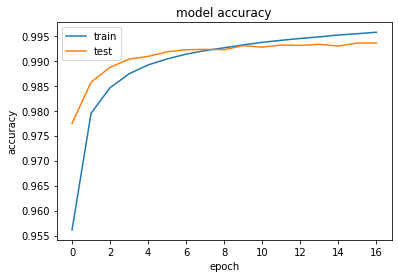

In [28]:
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

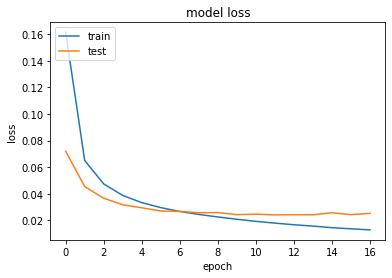

In [29]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Trying model<a class="anchor" id="3.3"></a>

In [30]:
def pred(val_input_ids,val_attention_mask):
    return model.predict([val_input_ids,val_attention_mask])

In [31]:
def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,128)
    val_attention = val_attention_mask.reshape(1,128)
    
    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    print("Original Text : ",str(sentence))
    print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    print("Original Tags : " ,str(true_enc_tag))
    print("\n")
    
    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1) 
    pred_without_pad = pred_with_pad[pred_with_pad>0]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)
    print("Predicted Tags : ",pred_enc_tag)
    

In [32]:
testing(val_input_ids[0],val_attention_mask[0],enc_tag,y_test[0])

Original Text :  [CLS] the report calls on president bush and congress to urge chinese officials not to use the global war against terrorism as a pretext to suppress minorities'rights. [SEP]


Original Tags :  ['O' 'O' 'O' 'O' 'B-per' 'I-per' 'O' 'B-org' 'O' 'O' 'B-gpe' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


Predicted Tags :  ['O' 'O' 'O' 'O' 'B-per' 'I-per' 'O' 'B-org' 'O' 'O' 'B-gpe' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
